In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 

In [78]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [79]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [ ]:
#filtering data to have similar chirp structure and eliminating redundancies in pulse pause and duration

def filter_data(x, dur_max):
    pd_df = x
    
    #finding frequency of each chirp duration
    (uniq, freq) = (np.unique(pd_df.CDUR, return_counts=True))
    xa = np.array([uniq,freq])
    xa = xa.astype(int)

    #finding the bracket of 61 values with the most data points
    jo = np.zeros(np.max(xa[0]))
    jo[xa[0]-1] = freq
    jo2 = []
    for i in range(30,len(jo)-30):
        jo2.append([i, np.sum(jo[i-30:i+30])])
    jo2 = np.array(jo2).T
    j = np.where(jo2 == np.max(jo2[1]))
    val = j[1][1] + 31

    #filtering down to values in the bracket calculated above
    x = pd_df.CDUR
    x1 = x>=(val-30)
    xa = pd_df[x1]
    x2 = xa.CDUR<=(val+30)
    xb = xa[x2]
    
    #repeating the same procedure for the values in chirp pause
    pd_df = xb
    (uniq, freq) = (np.unique(pd_df.CPAU, return_counts=True))
    xa = np.array([uniq,freq])
    xa = xa.astype(int)

    jo = np.zeros(np.max(xa[0]))
    jo[xa[0]-1] = freq
    jo2 = []
    for i in range(30,len(jo)-30):
        jo2.append([i, np.sum(jo[i-30:i+30])])
    jo2 = np.array(jo2).T
    j = np.where(jo2 == np.max(jo2[1]))
    val = j[1][1] + 31

    x = pd_df.CPAU
    x1 = x>=(val-30)
    xa = pd_df[x1]
    x2 = xa.CPAU<=(val+30)
    xb = xa[x2]

    #averaging the duplicates
    dfa = pd.DataFrame([xb.PDUR, xb.PPAU, xb.rXY]).T
    dfx = dfa.groupby(['PPAU', 'PDUR']).mean().reset_index()
    
    #filtering for values under the maximum duration specified
    check = dfx<=dur_max
    df_c = np.all(check,1)
    dfx = dfx[df_c]
    
    dfx = np.array([dfx.PDUR, dfx.PPAU, dfx.rXY]).T
    edg = [[0,0,0]]#, [0, dur_max, 0], [dur_max, dur_max, 0], [dur_max,0,0]] #initializing origin to zero (for smooth interpolation purposes)
    dfx = np.append(dfx, edg, axis = 0) 
    dfx = dfx.T
    
    plt.plot(dfx[0], dfx[1], 'o')
    plt.xlim(0, dur_max)
    plt.ylim(0, dur_max)
    plt.show()
    return dfx


In [ ]:
#Importing data from file

def import_data(dur_max, dur_step):

    pd_df = pd.read_csv("dat/OAX.txt")
    df = filter_data(pd_df, dur_max)
    
    pdur = df[0]
    ppau = df[1]
    phonotaxis = df[2]

    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = 0 #np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    
    ppf /= np.max(ppf)
    return ppf


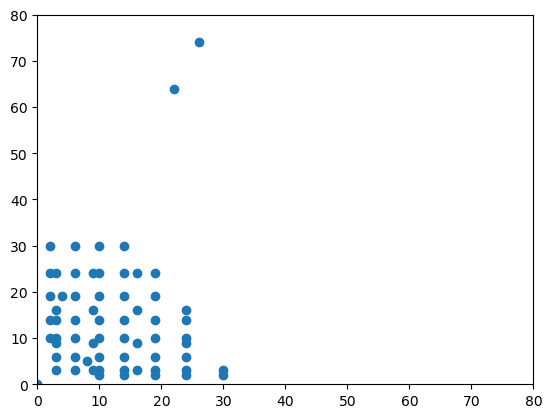

In [ ]:
#defining some global variables that are constant and used throughout the code

dur_max = 30  # ms
dur_step = 1.5 # ms
global pnt_ori, pdur_i, ppau_i
pnt_ori = import_data(dur_max, dur_step)
pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

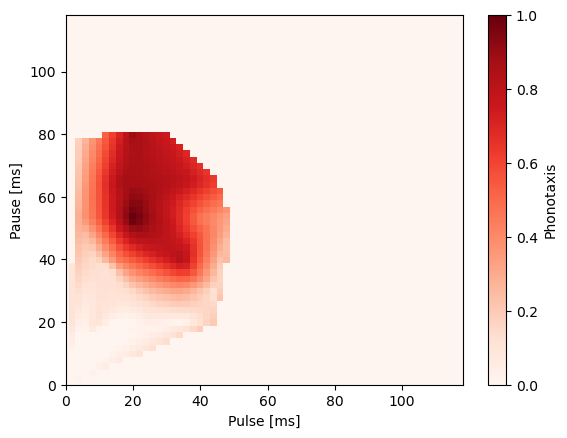

In [511]:
#For reference
plot_field(pdur_i, ppau_i, pnt_ori)

In [508]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [431]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [432]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [433]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [434]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [435]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

In [436]:
# ARM - [85, 5, 1.9, 0.07, 1.8, 12] (40, 0.5)
# FIR - [ 2.000e+01  4.000e+01  0.000e+00 -1.741e-05 3.070e-04  1.001e+00] (
# G14 - [ 3.648e+01  1.171e+01  1.511e+00 -4.538e-02 4.306e-01  4.562e+00] (50, 1) 

0.07088656781314605


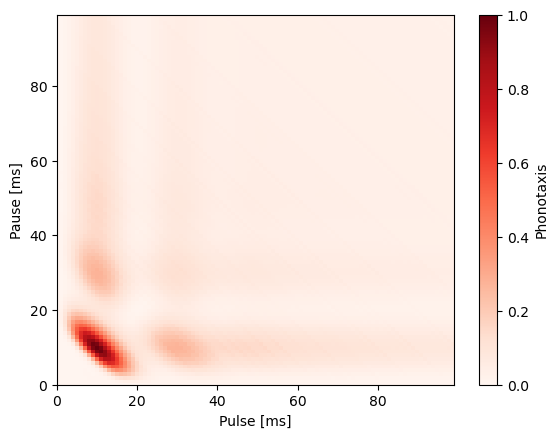

In [449]:
#setting initial values. and printing the start point of the minimize function present below
cfg = [50, 15, 0, 0, 0.05, 1]
y = sig_diff(cfg)
print(y)
xz = sig_diff2(cfg)
plot_field(pdur_i, ppau_i, xz[1])

In [442]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [444]:
#bounds of each parameter

b_fr = (0, 700)
b_sigma = (1, 501)
b_phi = (0, 2)
b_w = (-1, 1)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


#Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. , 'maxfev':1500  'options' : {"disp": True},  'bounds' : bnds, 
result = spo.basinhopping(sig_diff, cfg, niter = 150, minimizer_kwargs={'options' : {"disp": True }, 'bounds' : bnds,  'method' : 'L-BFGS-B'}) #stepsize = 0.9,

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.48852D-01    |proj g|=  1.00000D+00

At iterate    1    f=  1.48754D-01    |proj g|=  4.99926D-02

At iterate    2    f=  1.47884D-01    |proj g|=  4.05438D-01

At iterate    3    f=  1.46207D-01    |proj g|=  1.00026D+00

At iterate    4    f=  1.45487D-01    |proj g|=  9.99899D-01

At iterate    5    f=  1.45270D-01    |proj g|=  1.00008D+00

At iterate    6    f=  1.45160D-01    |proj g|=  9.36592D-01

At iterate    7    f=  1.45154D-01    |proj g|=  7.63012D-01

At iterate    8    f=  1.45106D-01    |proj g|=  9.99999D-01

At iterate    9    f=  1.45105D-01    |proj g|=  2.21740D-01

At iterate   10    f=  1.45105D-01    |proj g|=  2.12763D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   19    f=  2.64268D-01    |proj g|=  1.66228D-04

At iterate   20    f=  2.64268D-01    |proj g|=  1.65917D-04

At iterate   21    f=  2.64268D-01    |proj g|=  1.10000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21    114     22     2     0   1.100D+01   2.643D-01
  F =  0.26426809790848416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40987D-01    |proj g|=  9.56349D-01


/tmp/ipykernel_887/901067433.py:6: RuntimeWarning: overflow encountered in exp
  g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function



At iterate    1    f=  2.64370D-01    |proj g|=  1.11577D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1      2      2     0     1   1.116D-06   2.644D-01
  F =  0.26436996741097823     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64355D-01    |proj g|=  1.66117D-04

At iterate    1    f=  2.64355D-01    |proj g|=  1.66378D-04
  ys=-4.307E-11  -gs= 2.796E-08 BFGS update SKIPPED

At iterate    2  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     79     17     1     0   1.499D-03   2.642D-01
  F =  0.26419487298133021     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95925D-01    |proj g|=  9.31879D-01

At iterate    1    f=  2.64368D-01    |proj g|=  4.38538D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1      2      1     0     0   4.385D-06   2.644D-01
  F =  0.26436765862358086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 v


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   31    f=  2.15020D-01    |proj g|=  6.58129D-04

At iterate   32    f=  2.15018D-01    |proj g|=  1.40130D-04

At iterate   33    f=  2.15018D-01    |proj g|=  3.12722D-05

At iterate   34    f=  2.15018D-01    |proj g|=  2.04975D-05

At iterate   35    f=  2.15018D-01    |proj g|=  2.07057D-05

At iterate   36    f=  2.15018D-01    |proj g|=  5.54168D-05

At iterate   37    f=  2.15018D-01    |proj g|=  1.06271D-04

At iterate   38    f=  2.15018D-01    |proj g|=  1.87675D-04

At iterate   39    f=  2.15017D-01    |proj g|=  2.59090D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  2.15017D-01    |proj g|=  1.78485D-04

At iterate   41    f=  2.15017D-01    |proj g|=  2.81275D-05

At iterate   42    f=  2.15017D-01    |proj g|=  1.77081D-05

At iterate   43    f=  2.15017D-01    |proj g|=  1.78885D-05

At iterate   44    f=  2.15017D-01    |proj g|=  5.60024D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  2.15017D-01    |proj g|=  3.51885D-05

At iterate   46    f=  2.15017D-01    |proj g|=  1.74111D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   47    f=  2.15017D-01    |proj g|=  1.74305D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    175     51     0     0   1.743D-05   2.150D-01
  F =  0.21501674989999570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64372D-01    |proj g|=  4.32987D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   41    f=  2.14935D-01    |proj g|=  5.68157D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     88     42     0     0   5.682D-06   2.149D-01
  F =  0.21493450613847315     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.64370D-01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   17    f=  2.14955D-01    |proj g|=  7.12658D-04

At iterate   18    f=  2.14950D-01    |proj g|=  4.42696D-04

At iterate   19    f=  2.14950D-01    |proj g|=  8.00096D-04

At iterate   20    f=  2.14949D-01    |proj g|=  2.92680D-04

At iterate   21    f=  2.14948D-01    |proj g|=  1.12077D-04

At iterate   22    f=  2.14948D-01    |proj g|=  1.11161D-05

At iterate   23    f=  2.14948D-01    |proj g|=  1.54599D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     94     24     0     0   1.546D-06   2.149D-01
  F =  0.21494827694034110     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.17434D-01    |proj g|=  1.47638D-02

At iterate   21    f=  2.17429D-01    |proj g|=  8.57986D-03

At iterate   22    f=  2.17425D-01    |proj g|=  4.87475D-03

At iterate   23    f=  2.17424D-01    |proj g|=  1.84287D-03

At iterate   24    f=  2.17424D-01    |proj g|=  4.74787D-05

At iterate   25    f=  2.17424D-01    |proj g|=  4.78340D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     62     26     0     0   4.783D-05   2.174D-01
  F =  0.21742355432509403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.16594D-01    |proj g|=  3.09905D-02

At iterate   11    f=  2.16572D-01    |proj g|=  5.76251D-03

At iterate   12    f=  2.16572D-01    |proj g|=  1.61074D-04

At iterate   13    f=  2.16572D-01    |proj g|=  1.61537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     52     14     1     1   1.615D-04   2.166D-01
  F =  0.21657162858670426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   17    f=  2.16453D-01    |proj g|=  6.38076D-03

At iterate   18    f=  2.16453D-01    |proj g|=  7.02226D-03

At iterate   19    f=  2.16451D-01    |proj g|=  1.11156D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  2.16450D-01    |proj g|=  4.89737D-03

At iterate   21    f=  2.16450D-01    |proj g|=  4.03231D-03

At iterate   22    f=  2.16450D-01    |proj g|=  4.02110D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23    180     26     0     0   4.021D-03   2.165D-01
  F =  0.21645031431391867     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27948D-01    |proj g|=  1.27584D-01

At iterate    1    f=  2.27400D-01    |proj g|=  1.49158D-02

At iterate    2    f=  2.27390D-01    |proj g|=  1.91356D-03

At iterate    3    f=  2.27390D-01    |proj g|=  1.52496D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   38    f=  2.14927D-01    |proj g|=  3.17876D-04

At iterate   39    f=  2.14923D-01    |proj g|=  3.96558D-04

At iterate   40    f=  2.14922D-01    |proj g|=  3.98298D-04

At iterate   41    f=  2.14921D-01    |proj g|=  3.15797D-04

At iterate   42    f=  2.14920D-01    |proj g|=  2.06232D-04

At iterate   43    f=  2.14920D-01    |proj g|=  9.06247D-05

At iterate   44    f=  2.14920D-01    |proj g|=  3.81917D-05

At iterate   45    f=  2.14920D-01    |proj g|=  2.82274D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45    124     46     0     0   2.823D-06   2.149D-01
  F =  0.214920187632


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   14    f=  2.18880D-01    |proj g|=  4.63891D-03

At iterate   15    f=  2.18880D-01    |proj g|=  4.04638D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   16    f=  2.18880D-01    |proj g|=  4.03928D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   17    f=  2.18880D-01    |proj g|=  4.03898D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17    134     19     0     1   4.039D-03   2.189D-01
  F =  0.21887987991680752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.43946D-01    |proj g|=  3.78877D-01

At iterate    1    f=  2.42859D-01    |proj g|=  2.74588D-01

At iterate    2    f=  2.42405D-01    |proj g|=  2.16932D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   16    f=  2.25345D-01    |proj g|=  7.97592D-02

At iterate   17    f=  2.17381D-01    |proj g|=  9.36767D-02

At iterate   18    f=  2.17255D-01    |proj g|=  1.44608D-02

At iterate   19    f=  2.17253D-01    |proj g|=  1.80257D-03

At iterate   20    f=  2.17252D-01    |proj g|=  8.91012D-04

At iterate   21    f=  2.17252D-01    |proj g|=  2.00195D-04

At iterate   22    f=  2.17252D-01    |proj g|=  1.26749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     70     23     0     0   1.267D-04   2.173D-01
  F =  0.21725241126992195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   27    f=  2.75095D-01    |proj g|=  5.97679D-02

At iterate   28    f=  2.64368D-01    |proj g|=  2.72560D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     88     29     1     0   2.726D-06   2.644D-01
  F =  0.26436797370158788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  7.94209D-01    |proj g|=  1.10437D+00

At iterate    1    f=  2.64362D-01    |proj g|=  3.15858D-06

       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   14    f=  2.17673D-01    |proj g|=  3.83322D-02

At iterate   15    f=  2.17412D-01    |proj g|=  1.11825D-02

At iterate   16    f=  2.17398D-01    |proj g|=  2.51967D-02

At iterate   17    f=  2.17109D-01    |proj g|=  3.71588D-02

At iterate   18    f=  2.17109D-01    |proj g|=  3.50673D-02

At iterate   19    f=  2.16901D-01    |proj g|=  3.00179D-02

At iterate   20    f=  2.16862D-01    |proj g|=  1.55028D-02

At iterate   21    f=  2.16846D-01    |proj g|=  1.35130D-02

At iterate   22    f=  2.16843D-01    |proj g|=  3.76932D-04

At iterate   23    f=  2.16843D-01    |proj g|=  3.77376D-04

At iterate   24    f=  2.16843D-01    |proj g|=  8.29514D-04

At iterate   25    f=  2.16843D-01    |proj g|=  1.84757D-03

At iterate   26    f=  2.16843D-01    |proj g|=  3.64385D-03

At iterate   27    f=  2.16842D-01    |proj g|=  6.40525D-03

At iterate   28    f=  2.16840D-01    |proj g|=  1.07483D-02

At iterate   29    f=  2.16836D-01    |proj g|=  1.65142D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   34    f=  2.16776D-01    |proj g|=  2.74674D-02

At iterate   35    f=  2.16771D-01    |proj g|=  1.47134D-02

At iterate   36    f=  2.16765D-01    |proj g|=  8.27345D-03

At iterate   37    f=  2.16763D-01    |proj g|=  3.79328D-03

At iterate   38    f=  2.16762D-01    |proj g|=  4.86330D-04

At iterate   39    f=  2.16762D-01    |proj g|=  1.92946D-04

At iterate   40    f=  2.16762D-01    |proj g|=  1.92141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40    111     42     0     0   1.921D-04   2.168D-01
  F =  0.21676241646662323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  2.14963D-01    |proj g|=  4.95062D-04

At iterate   26    f=  2.14962D-01    |proj g|=  2.43761D-04

At iterate   27    f=  2.14961D-01    |proj g|=  3.26361D-04

At iterate   28    f=  2.14960D-01    |proj g|=  2.63667D-04

At iterate   29    f=  2.14959D-01    |proj g|=  2.11825D-04

At iterate   30    f=  2.14959D-01    |proj g|=  3.48943D-05

At iterate   31    f=  2.14959D-01    |proj g|=  1.31617D-05

At iterate   32    f=  2.14959D-01    |proj g|=  1.30784D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     72     33     0     0   1.308D-05   2.150D-01
  F =  0.214958867472


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.14939D-01    |proj g|=  3.98848D-05

At iterate   11    f=  2.14939D-01    |proj g|=  1.03584D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     69     12     0     1   1.036D-05   2.149D-01
  F =  0.21493906668414708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.28180D-01    |proj g|=  2.28935D-01

At iterate    1    f=  2.18841D-01    |proj g|=  3.17074D-01
  ys=-3.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  2.14912D-01    |proj g|=  9.06725D-03

At iterate   23    f=  2.14912D-01    |proj g|=  5.81276D-03

At iterate   24    f=  2.14911D-01    |proj g|=  5.64641D-03

At iterate   25    f=  2.14910D-01    |proj g|=  1.56445D-02

At iterate   26    f=  2.14908D-01    |proj g|=  2.97861D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   27    f=  2.14905D-01    |proj g|=  5.68759D-03

At iterate   28    f=  2.14905D-01    |proj g|=  5.81309D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   29    f=  2.14905D-01    |proj g|=  5.80007D-03

At iterate   30    f=  2.14905D-01    |proj g|=  5.79958D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31    194     35     1     0   5.800D-03   2.149D-01
  F =  0.21490498637015390     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.18614D-01    |proj g|=  8.54831D-02

At iterate    1    f=  2.17840D-01    |proj g|=  4.11523D-02

At iterate    2    f=  2.17656D-01    |proj g|=  6.25021D-03

At iterate    3    f=  2.17648D-01    |proj g|=  5.02052D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   18    f=  2.19325D-01    |proj g|=  3.58691D-04

At iterate   19    f=  2.19325D-01    |proj g|=  6.71435D-05

At iterate   20    f=  2.19325D-01    |proj g|=  1.14866D-04

At iterate   21    f=  2.19324D-01    |proj g|=  1.01603D-03

At iterate   22    f=  2.19324D-01    |proj g|=  2.18560D-03

At iterate   23    f=  2.19323D-01    |proj g|=  3.01185D-03

At iterate   24    f=  2.19323D-01    |proj g|=  3.02293D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  2.19323D-01    |proj g|=  3.02297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     91     26     0     1   3.023D-03   2.193D-01
  F =  0.21932262095921884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67634D-01    |proj g|=  1.04283D+00

At iterate    1    f=  2.64387D-01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total nu

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.14510543196668316
                          x: [ 5.000e+01  1.500e+01  0.000e+00 -7.505e-07
                               7.749e-04  1.001e+00]
                        nit: 150
      minimization_failures: 3
                       nfev: 16961
                       njev: 2423
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.14510543196668316
                                    x: [ 5.000e+01  1.500e+01  0.000e+00
                                        -7.505e-07  7.749e-04  1.001e+00]
                                  nit: 10
                                  jac: [-4.284e-03  6.125e-04  3.689e-05
                                        -2.128e-01  4.994e-03 -1

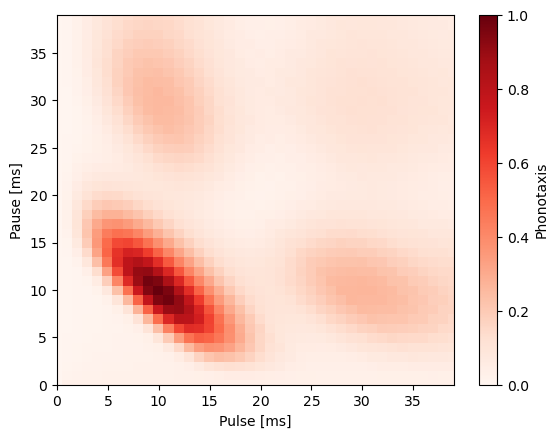

In [445]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xe = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xe[1])

128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
[0.17580477536050695, 137, 2]


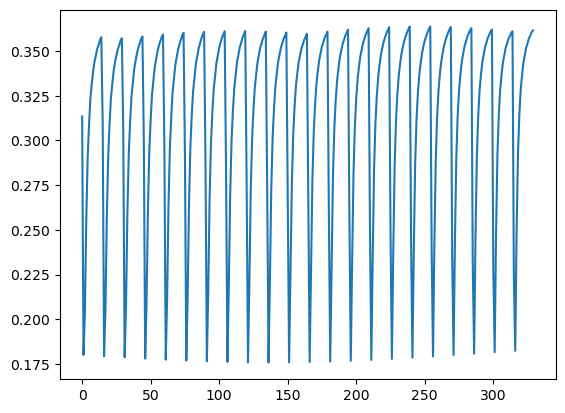

In [400]:
cfg1 = [1,0,0]
vals = []
for i in range(128, 150):
    print(i)
    for j in range(1, 16):
        cfg = [i, j, 0, 0, 0.05, 1]
        x = sig_diff(cfg)
        vals.append(x)
        if cfg1[0] > x:
            cfg1 = [x, i, j]
    
print(cfg1)
plt.plot(vals)
plt.show()